In [1]:
import os
import time
import collections
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from IPython.display import display

In [2]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# 0. Load Data

In [3]:
%%time
data = pd.read_pickle('../data/WM-811k/LSWMD.pkl')
display(data.head(10))

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]
5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,6.0,[[Training]],[[none]]
6,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,7.0,[[Training]],[[none]]
7,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,8.0,[[Training]],[[none]]
8,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,9.0,[[Training]],[[none]]
9,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,10.0,[[Training]],[[none]]


CPU times: user 2min 21s, sys: 2.61 s, total: 2min 24s
Wall time: 2min 23s


# 1. Preprocessing

## 1-1. Refine class labels

In [4]:
def getLabelString(x):
    if len(x) == 1:
        # Labeled (9 classes)
        ls = x[0][0].strip().lower()
    else:
        # Unlabeled (majority)
        ls = '-'
    return ls

In [5]:
%%time
data['labelString'] = data['failureType'].apply(getLabelString)
display(data.head(10))

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,labelString
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]],none
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]],none
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]],none
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]],none
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]],none
5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,6.0,[[Training]],[[none]],none
6,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,7.0,[[Training]],[[none]],none
7,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,8.0,[[Training]],[[none]],none
8,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,9.0,[[Training]],[[none]],none
9,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,10.0,[[Training]],[[none]],none


CPU times: user 1.12 s, sys: 16.1 ms, total: 1.14 s
Wall time: 1.14 s


In [6]:
label_counts = collections.Counter(data['labelString'])
total_counts = 0
for label, count in label_counts.items():
    print(f"{label:<10}: {count:>8,}")
    if label != '-':
        total_counts += count
    
print('-' * 30)
print(f"Total labeled samples: {total_counts:,}")

none      :  147,431
loc       :    3,593
-         :  638,507
edge-loc  :    5,189
center    :    4,294
edge-ring :    9,680
scratch   :    1,193
random    :      866
near-full :      149
donut     :      555
------------------------------
Total labeled samples: 172,950


## 1-2. Refine train test labels

In [7]:
def getTrainTestLabel(x):
    d = {
        'unlabeled': -1,
        'training': 0,
        'test': 1,
    }
    if len(x) == 1:
        lb = x[0][0].strip().lower()  # 'training' or 'test'
    else:
        lb = 'unlabeled'              # empty
    return d[lb]

In [8]:
%%time
data['trainTestLabel'] = data['trianTestLabel'].apply(getTrainTestLabel)
display(data.head(10))

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,labelString,trainTestLabel
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]],none,0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]],none,0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]],none,0
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]],none,0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]],none,0
5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,6.0,[[Training]],[[none]],none,0
6,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,7.0,[[Training]],[[none]],none,0
7,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,8.0,[[Training]],[[none]],none,0
8,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,9.0,[[Training]],[[none]],none,0
9,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,10.0,[[Training]],[[none]],none,0


CPU times: user 1.62 s, sys: 0 ns, total: 1.62 s
Wall time: 1.62 s


In [9]:
data['trainTestLabel'].value_counts(normalize=False)

-1    638507
 1    118595
 0     54355
Name: trainTestLabel, dtype: int64

In [10]:
118595 + 54355

172950

## 1-3. Get wafer map dimensions

In [11]:
%%time
data['waferMapDim'] = data['waferMap'].apply(lambda x: x.shape)
display(data.head(10))

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,labelString,trainTestLabel,waferMapDim
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]],none,0,"(45, 48)"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]],none,0,"(45, 48)"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]],none,0,"(45, 48)"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]],none,0,"(45, 48)"
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]],none,0,"(45, 48)"
5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,6.0,[[Training]],[[none]],none,0,"(45, 48)"
6,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,7.0,[[Training]],[[none]],none,0,"(45, 48)"
7,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,8.0,[[Training]],[[none]],none,0,"(45, 48)"
8,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,9.0,[[Training]],[[none]],none,0,"(45, 48)"
9,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,10.0,[[Training]],[[none]],none,0,"(45, 48)"


CPU times: user 1.02 s, sys: 26 µs, total: 1.02 s
Wall time: 1.02 s


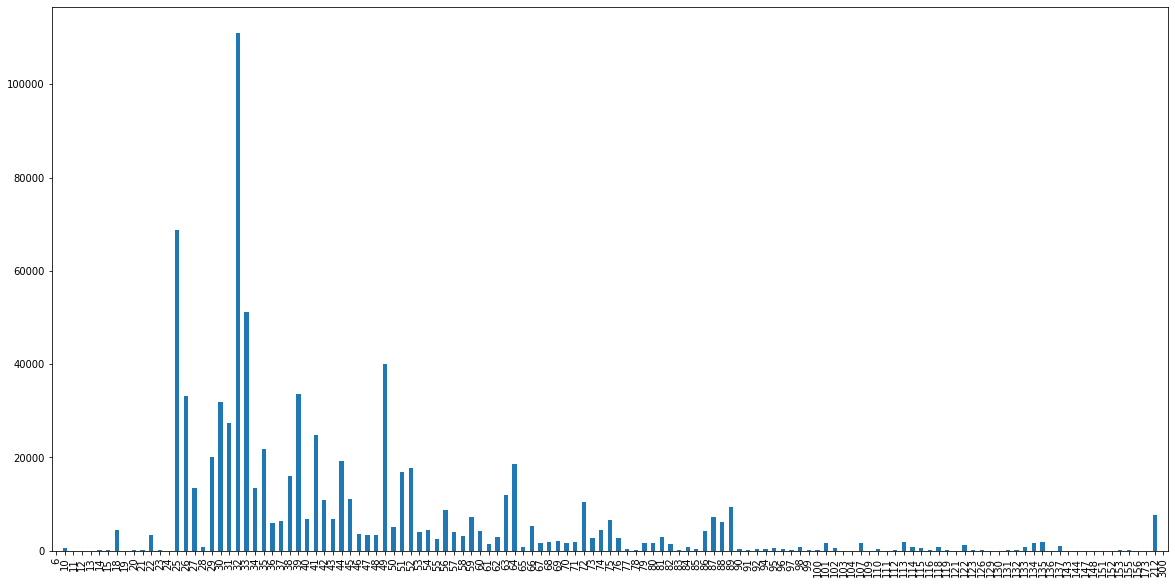

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
data.waferMapDim.apply(lambda x: x[0]).value_counts().sort_index().plot.bar(ax=ax)
plt.show(fig)

In [35]:
data['singleDim'] = data['waferMapDim'].apply(lambda x: (x[0] // 10) * 10)

In [36]:
import seaborn as sns

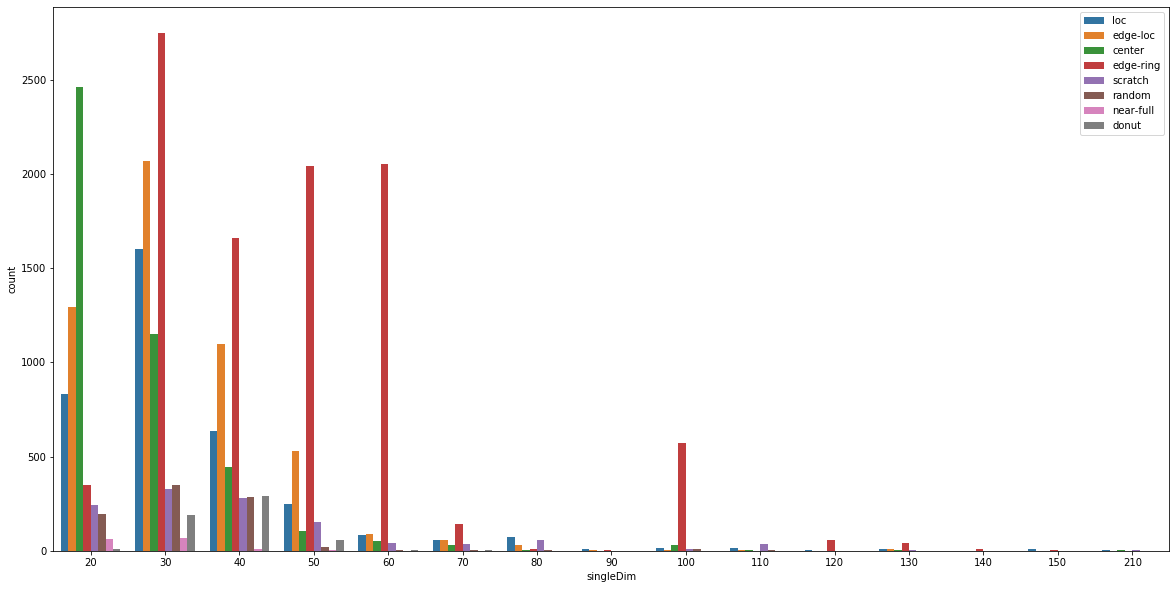

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.countplot(data=data.loc[~data.labelString.isin(['-', 'none'])], x='singleDim', hue='labelString', ax=ax)
ax.legend(loc='upper right')
plt.show(fig)

## 1-4. Get wafer map sizes

In [12]:
%%time
data['waferMapSize'] = data['waferMapDim'].apply(lambda x: x[0] * x[1])
display(data.head(10))

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,labelString,trainTestLabel,waferMapDim,waferMapSize
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]],none,0,"(45, 48)",2160
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]],none,0,"(45, 48)",2160
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]],none,0,"(45, 48)",2160
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]],none,0,"(45, 48)",2160
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]],none,0,"(45, 48)",2160
5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,6.0,[[Training]],[[none]],none,0,"(45, 48)",2160
6,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,7.0,[[Training]],[[none]],none,0,"(45, 48)",2160
7,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,8.0,[[Training]],[[none]],none,0,"(45, 48)",2160
8,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,9.0,[[Training]],[[none]],none,0,"(45, 48)",2160
9,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,10.0,[[Training]],[[none]],none,0,"(45, 48)",2160


CPU times: user 1.15 s, sys: 3.82 ms, total: 1.15 s
Wall time: 1.15 s


## 1-5. Refine lot names & wafer indices

In [12]:
%%time
data['lotName'] = data['lotName'].apply(lambda x: x.replace('lot', ''))
data['waferIndex'] = data['waferIndex'].astype(int)
display(data.head(10))

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,labelString,trainTestLabel,waferMapDim,waferMapSize
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,1,1,[[Training]],[[none]],none,-1,"(45, 48)",2160
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,1,2,[[Training]],[[none]],none,-1,"(45, 48)",2160
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,1,3,[[Training]],[[none]],none,-1,"(45, 48)",2160
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,1,4,[[Training]],[[none]],none,-1,"(45, 48)",2160
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,1,5,[[Training]],[[none]],none,-1,"(45, 48)",2160
5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,1,6,[[Training]],[[none]],none,-1,"(45, 48)",2160
6,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,1,7,[[Training]],[[none]],none,-1,"(45, 48)",2160
7,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,1,8,[[Training]],[[none]],none,-1,"(45, 48)",2160
8,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,1,9,[[Training]],[[none]],none,-1,"(45, 48)",2160
9,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,1,10,[[Training]],[[none]],none,-1,"(45, 48)",2160


CPU times: user 1.04 s, sys: 12 ms, total: 1.06 s
Wall time: 1.05 s


# 2. Class distributions

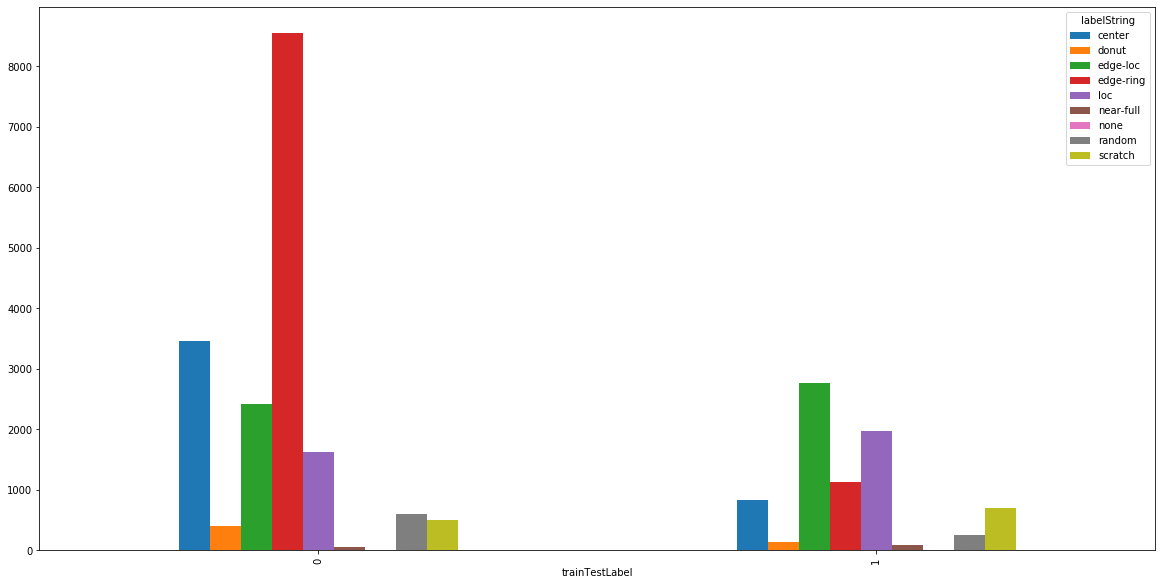

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
table = pd.crosstab(index=data['trainTestLabel'], columns=data['labelString'])
table = table.loc[table.index > -1]
table.plot.bar(ax=ax)
plt.show(fig)

# 4. Resizing

In [14]:
out = data[['waferMap', 'trainTestLabel', 'labelString', 'waferMapDim', 'waferMapSize', 'lotName', 'waferIndex']]
display(out[out.labelString != 'none'].sample(30))

,waferMap,trainTestLabel,labelString,waferMapDim,waferMapSize,lotName,waferIndex
151831,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,loc,"(64, 71)",4544,9816,14
21105,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,...",0,edge-ring,"(38, 36)",1368,2507,6
728696,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,...",1,near-full,"(33, 29)",957,44182,3
56768,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2,...",0,edge-loc,"(32, 29)",928,4548,6
187320,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,...",0,edge-ring,"(38, 38)",1444,11885,12
724793,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1,...",1,edge-loc,"(25, 26)",650,44022,13
744043,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,edge-ring,"(43, 42)",1806,44806,3
76440,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",0,loc,"(33, 33)",1089,5654,5
20982,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,...",0,edge-ring,"(38, 36)",1368,2502,6
145127,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,...",0,edge-ring,"(38, 38)",1444,9344,16


In [15]:
def nearest_interpolate(a, s=(40, 40)):
    assert len(a.shape) == 2
    b = torch.from_numpy(a).view(1, 1, *a.shape).float()
    return F.interpolate(b, size=s, mode='nearest').squeeze().long().numpy()

In [16]:
def max_interpolate(a, s=(40, 40)):
    assert len(a.shape) == 2
    b = torch.from_numpy(a).view(1, 1, *a.shape).float()
    return nn.AdaptiveMaxPool2d(s)(b).squeeze().long().numpy()

In [17]:
def avg_interpolate(a, s=(40, 40)):
    assert len(a.shape) == 2
    b = torch.from_numpy(a).view(1, 1, *a.shape).float()
    return nn.AdaptiveAvgPool2d(s)(b).squeeze().long().numpy()

In [19]:
i = 187173

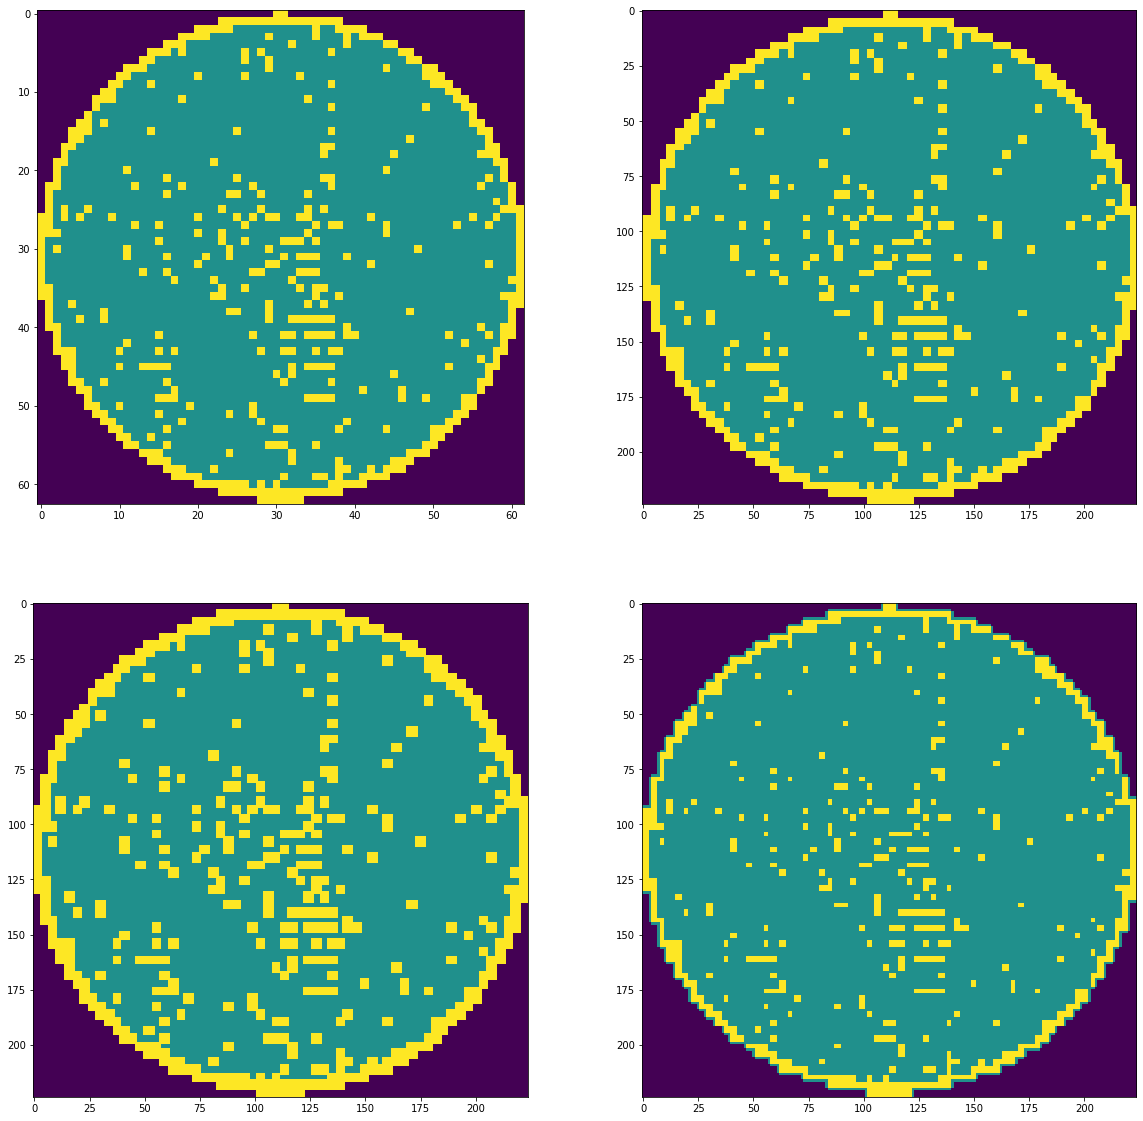

In [20]:
s = (224, 224)
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
axes[0][0].imshow(out['waferMap'][i])
axes[0][1].imshow(nearest_interpolate(out['waferMap'][i], s=s))
axes[1][0].imshow(max_interpolate(out['waferMap'][i], s=s))
axes[1][1].imshow(avg_interpolate(out['waferMap'][i], s=s))
plt.show(fig)

In [28]:
from PIL import Image
from torchvision.transforms import Resize, RandomRotation, Compose

In [29]:
arr = out.loc[i, 'waferMap']
img = Image.fromarray(((arr / 2) * 255).astype(np.uint8))

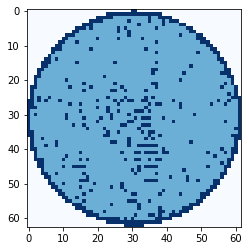

In [34]:
plt.imshow(img, cmap=plt.cm.Blues)

In [35]:
transforms = Compose(
    [
        Resize((112, 112), interpolation=Image.NEAREST),
        RandomRotation(360, fill=(0, ))
    ]
)

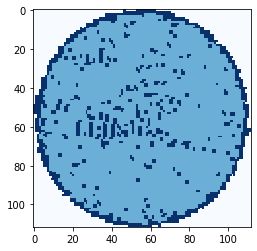

In [40]:
img_t = transforms(img)
plt.imshow(img_t, cmap=plt.cm.Blues)

In [22]:
temp = out.loc[i, 'waferMap']

In [23]:
temp

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [70]:
from PIL import Image

In [104]:
def save_image(file: str, arr: np.ndarray, vmin=0, vmax=2):
    from PIL import Image
    scaled_arr = (arr / vmax) * 255
    img = Image.fromarray(scaled_arr.astype(np.uint8))
    img.save(file)

In [105]:
save_image('../temp.png', out.loc[125548, 'waferMap'])

In [106]:
def load_image(file: str, vmin=0, vmax=2):
    from PIL import Image
    img = Image.open(file)
    return img

In [108]:
img = load_image('../temp.png')

In [129]:
for wm in out['waferMap']:
    print(wm)
    break

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [128]:
next(iter(out['waferMap']))

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [110]:
img.mode

'L'

In [111]:
from torchvision.transforms import Resize
from torchvision.transforms import RandomRotation
from torchvision.transforms import Normalize, ToTensor

In [86]:
img = Image.fromarray((temp / 2 * 255).astype(np.uint8))

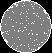

In [87]:
img

In [124]:
np.unique(ToTensor()(Resize(size=(100, 100), interpolation=0)(img)).numpy())

array([0.        , 0.49803922, 1.        ], dtype=float32)

In [116]:
np.unique(ToTensor()(img).numpy())

array([0.        , 0.49803922, 1.        ], dtype=float32)

In [88]:
img.save('../temp.png')

In [90]:
img = Image.open('../temp.png')

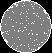

In [91]:
img

In [100]:
np.asarray(img) / 255 * 2

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [52]:
plt.imsave('../temp.png', temp.astype(np.uint8), vmin=0, vmax=2, cmap=plt.cm.Blues)

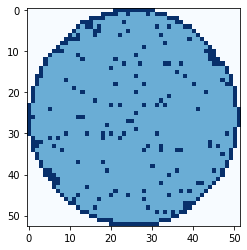

In [47]:
plt.imshow(temp, cmap=plt.cm.Blues)

In [58]:
a = Image.open('../temp.png')

In [62]:
np.unique(np.array(a))

array([  8,  48, 106, 107, 173, 213, 247, 251, 255], dtype=uint8)

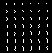

In [57]:
Image.fromarray(temp, mode='1')

In [99]:
temp = out.loc[out['trainTestLabel'] == 0, ['waferMap', 'labelString']]

In [100]:
temp['waferMapResized'] = temp['waferMap'].apply(nearest_interpolate, s=(112, 112))

In [102]:
png_dir = '../tempvis2/'
os.makedirs(png_dir, exist_ok=True)
for i, row in temp.iterrows():
    label = row['labelString']
    im = Image.fromarray((row['waferMapResized'] * 255/2).astype(np.uint8))
    im.save(os.path.join(png_dir, f'{label}_{i}.png'))

# Save

In [ ]:
# Reset index
out = out.reset_index(drop=True, inplace=False)
display(out.head(10))

In [ ]:
%%time
out['waferMap'] = out['waferMap'].apply(nearest_interpolate)

In [ ]:
unique_labels = list(out['label'].unique()) 

In [ ]:
label2idx = {l: i for i, l in enumerate(unique_labels)}
label2idx

In [ ]:
index2label = {v: k for k, v in label2idx.items()}
index2label

In [ ]:
# Get train, validation, test indices (stratify with label)
train_indices, temp_indices = train_test_split(out.index, train_size=0.8, shuffle=True, stratify=out.label, random_state=2015010720)
valid_indices, test_indices = train_test_split(temp_indices, train_size=.5, shuffle=True, stratify=out.label[temp_indices], random_state=2015010720)
print(f'Train : Validation : Test = {len(train_indices)} : {len(valid_indices)} : {len(test_indices)}')

In [ ]:
X = np.stack(out['waferMap'], axis=0)  # (B, H, W)
X = np.expand_dims(X, axis=1)          # (B, 1, H, W)
X = X.astype(np.float32)

In [ ]:
y = label2idx[;]

In [ ]:
X.__len__()

In [ ]:
np.savez(
    '../data/processed/WM811k.40.npz'
    x_train=out.loc[train_indices, 'waferMap']
)

In [ ]:


len(valid_indices)

In [ ]:
len(test_indices)